In [1]:
import pandas as pd
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## Анализ структуры и предобработка данных

### Информаця о структуре

In [2]:
print("\nИнформация о данных:")
print(data.info())


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB
None


In [3]:
print("\nОсновные статистики:")
print(data.describe())


Основные статистики:
             user_id       purchase          price
count  294478.000000  294478.000000  294478.000000
mean   787974.124733       0.119659   10154.782361
std     91210.823776       0.324563   35153.824872
min    630000.000000       0.000000       0.000000
25%    709032.250000       0.000000       0.000000
50%    787933.500000       0.000000       0.000000
75%    866911.750000       0.000000       0.000000
max    945999.000000       1.000000  200000.000000


In [4]:
print("\nУникальные значения в столбце 'group':")
print(data['group'].value_counts())


Уникальные значения в столбце 'group':
group
B    147276
A    147202
Name: count, dtype: int64


### Преобразование к типу данных

In [5]:
#Преобразуем дату в datetime
data['date'] = pd.to_datetime(data['date'])
#Преобразуем group в категориальный тип
data['group'] = data['group'].astype('category')
#Преобразуем purchase в булевый тип (0/1)
data['purchase'] = data['purchase'].astype(bool)

In [6]:
print("Типы данных после преобразования:")
print(data.dtypes)

Типы данных после преобразования:
user_id              int64
date        datetime64[ns]
group             category
purchase              bool
price                int64
dtype: object


### Длительность a/b тестирования

In [7]:
#Находим минимальную и максимальную дату для каждой группы
date_range_by_group = data.groupby('group')['date'].agg(['min', 'max'])
date_range_by_group['duration'] = (date_range_by_group['max'] - date_range_by_group['min']).dt.days

In [8]:
print("Диапазон дат по группам:")
print(date_range_by_group)
#Если длительности отличаются, можно обрезать данные до общего периода
if len(date_range_by_group['duration'].unique()) > 1:
    print("Длительности тестирования различаются между группами!")
    common_start = date_range_by_group['min'].max()
    common_end = date_range_by_group['max'].min()
    print(f"Общий период тестирования: с {common_start} по {common_end}")
    #Обрезаем данные до общего периода
    data = data[(data['date'] >= common_start) & (data['date'] <= common_end)]
    print(f"Размер данных после обрезки: {data.shape}")
else:
    print("Длительности тестирования одинаковы для всех групп!")

Диапазон дат по группам:
             min        max  duration
group                                
A     2021-01-02 2021-01-24        22
B     2021-01-02 2021-01-24        22
Длительности тестирования одинаковы для всех групп!


### Пропуски

In [9]:
missing_values = data.isnull().sum()
print("Пропущенные значения:")
print(missing_values)
#Удаляем строки с пропусками, если они есть
if missing_values.sum() > 0:
    print("Удаляем строки с пропусками...")
    data = data.dropna()
    print(f"Размер данных после удаления пропусков: {data.shape}")
else:
    print("Пропущенных значений нет")

Пропущенные значения:
user_id     0
date        0
group       0
purchase    0
price       0
dtype: int64
Пропущенных значений нет


### Проверка пользователей в обеих группах

In [10]:
#Находим пользователей, которые были в обеих группах
users_in_both_groups = data.groupby('user_id')['group'].nunique()
users_in_multiple_groups = users_in_both_groups[users_in_both_groups > 1]
print(f"Количество пользователей в обеих группах: {len(users_in_multiple_groups)}")
if len(users_in_multiple_groups) > 0:
    print("Найдены пользователи, которые были в обеих группах!")
    print("Исключаем этих пользователей из анализа...")
    #Получаем ID пользователей для исключения
    users_to_exclude = users_in_multiple_groups.index.tolist()
    #Сохраняем информацию об исключенных пользователях
    excluded_data = data[data['user_id'].isin(users_to_exclude)]
    print(f"Будет исключено {len(excluded_data)} записей")
    #Исключаем пользователей
    data = data[~data['user_id'].isin(users_to_exclude)]
    print(f"Размер данных после исключения: {data.shape}")
else:
    print("Пользователей в обеих группах не найдено!")

Количество пользователей в обеих группах: 1895
Найдены пользователи, которые были в обеих группах!
Исключаем этих пользователей из анализа...
Будет исключено 3790 записей
Размер данных после исключения: (290688, 5)


### Цены

In [11]:
print("\nРаспределение по группам:")
print(data['group'].value_counts())
print("\nСтатистики по покупкам:")
print(data['purchase'].value_counts())
print(f"Конверсия: {data['purchase'].mean():.4f}")
print("\nСтатистики по ценам:")
print(data['price'].describe())
print(f"Средний чек: {data[data['purchase']]['price'].mean():.2f}")


Распределение по группам:
group
B    145381
A    145307
Name: count, dtype: int64

Статистики по покупкам:
purchase
False    255911
True      34777
Name: count, dtype: int64
Конверсия: 0.1196

Статистики по ценам:
count    290688.000000
mean      10151.055427
std       35152.835088
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      200000.000000
Name: price, dtype: float64
Средний чек: 84848.89


## Первичный анализ результатов a/b тестов

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Вспомогательные харакетристики по группам

In [13]:
group_stats = data.groupby('group').agg(
    visits=('user_id', 'count'),  #количество посещений
    purchases=('purchase', 'sum'),  #количество покупок
    total_revenue=('price', 'sum')  #сумма всех покупок
).reset_index()

In [14]:
group_stats['conversion_rate'] = group_stats['purchases'] / group_stats['visits']
group_stats['average_order_value'] = group_stats['total_revenue'] / group_stats['purchases']

print(group_stats)
print("\n")

  group  visits  purchases  total_revenue  conversion_rate   
0     A  145307      17487     1417780000         0.120345  \
1     B  145381      17290     1533010000         0.118929   

   average_order_value  
0         81076.228055  
1         88664.545980  




### Промежуточные выводы

In [15]:
print("Сопоставимость количества посещений:")
visit_ratio = group_stats[group_stats['group'] == 'B']['visits'].values[0] / group_stats[group_stats['group'] == 'A']['visits'].values[0]
print(f"Соотношение посещений (B/A): {visit_ratio:.3f}")
if 0.9 <= visit_ratio <= 1.1:
    print("Количество посещений сопоставимо (разница менее 10%)")
else:
    print("Количество посещений существенно отличается")
print("\nБалансировка выборок:")
total_visits = group_stats['visits'].sum()
for group in ['A', 'B']:
    group_share = group_stats[group_stats['group'] == group]['visits'].values[0] / total_visits
    print(f"   Группа {group}: {group_share:.1%} посещений")
if 0.45 <= group_stats[group_stats['group'] == 'A']['visits'].values[0] / total_visits <= 0.55:
    print("Выборки сбалансированы")
else:
    print("Выборки несбалансированы")

Сопоставимость количества посещений:
Соотношение посещений (B/A): 1.001
Количество посещений сопоставимо (разница менее 10%)

Балансировка выборок:
   Группа A: 50.0% посещений
   Группа B: 50.0% посещений
Выборки сбалансированы


### Ключевые характеристики и первичные выводы

In [16]:
print("Ключевые метрики по группам:")
key_metrics = group_stats[['group', 'conversion_rate', 'average_order_value', 'total_revenue']].copy()
key_metrics['conversion_rate'] = key_metrics['conversion_rate'].round(4)
key_metrics['average_order_value'] = key_metrics['average_order_value'].round(2)
print(key_metrics)
#Сравнение показателей
conv_A = group_stats[group_stats['group'] == 'A']['conversion_rate'].values[0]
conv_B = group_stats[group_stats['group'] == 'B']['conversion_rate'].values[0]
aov_A = group_stats[group_stats['group'] == 'A']['average_order_value'].values[0]
aov_B = group_stats[group_stats['group'] == 'B']['average_order_value'].values[0]
conv_diff = ((conv_B - conv_A) / conv_A) * 100
aov_diff = ((aov_B - aov_A) / aov_A) * 100
print(f"\nСравнение конверсии:")
print(f"   Группа A: {conv_A:.4f}")
print(f"   Группа B: {conv_B:.4f}")
print(f"   Разница: {conv_diff:+.1f}%")
print(f"\nСравнение среднего чека:")
print(f"   Группа A: {aov_A:.2f}")
print(f"   Группа B: {aov_B:.2f}")
print(f"   Разница: {aov_diff:+.1f}%")
#Первичные выводы
print(f"\nВыводы:")
if conv_B > conv_A:
    print("Тестовая группа B показывает более высокую конверсию")
else:
    print("Контрольная группа A показывает более высокую конверсию")
if aov_B > aov_A:
    print("Тестовая группа B показывает более высокий средний чек")
else:
    print("Контрольная группа A показывает более высокий средний чек")

Ключевые метрики по группам:
  group  conversion_rate  average_order_value  total_revenue
0     A           0.1203             81076.23     1417780000
1     B           0.1189             88664.55     1533010000

Сравнение конверсии:
   Группа A: 0.1203
   Группа B: 0.1189
   Разница: -1.2%

Сравнение среднего чека:
   Группа A: 81076.23
   Группа B: 88664.55
   Разница: +9.4%

Выводы:
Контрольная группа A показывает более высокую конверсию
Тестовая группа B показывает более высокий средний чек


### Анализ покупательской способности по ценам туров

In [17]:
#Создаем сводную таблицу
pivot_data = data[data['purchase'] == True]  #только покупки
price_analysis = pivot_data.pivot_table(
    index='price',
    columns='group',
    values='user_id',
    aggfunc='count',
    fill_value=0
).reset_index()
price_analysis.columns = ['price', 'group_A_purchases', 'group_B_purchases']
price_analysis['total_purchases'] = price_analysis['group_A_purchases'] + price_analysis['group_B_purchases']
price_analysis['B_vs_A_ratio'] = price_analysis['group_B_purchases'] / price_analysis['group_A_purchases'].replace(0, 0.001)
print("Сводная таблица: зависимость количества продаж от группы и цены тура")
print(price_analysis.sort_values('price'))

Сводная таблица: зависимость количества продаж от группы и цены тура
    price  group_A_purchases  group_B_purchases  total_purchases  B_vs_A_ratio
0   10000               5182               5201            10383      1.003667
1   60000               5271               1730             7001      0.328211
2  100000               1832               5227             7059      2.853166
3  150000               3478               3438             6916      0.988499
4  200000               1724               1694             3418      0.982599


### Визуализация

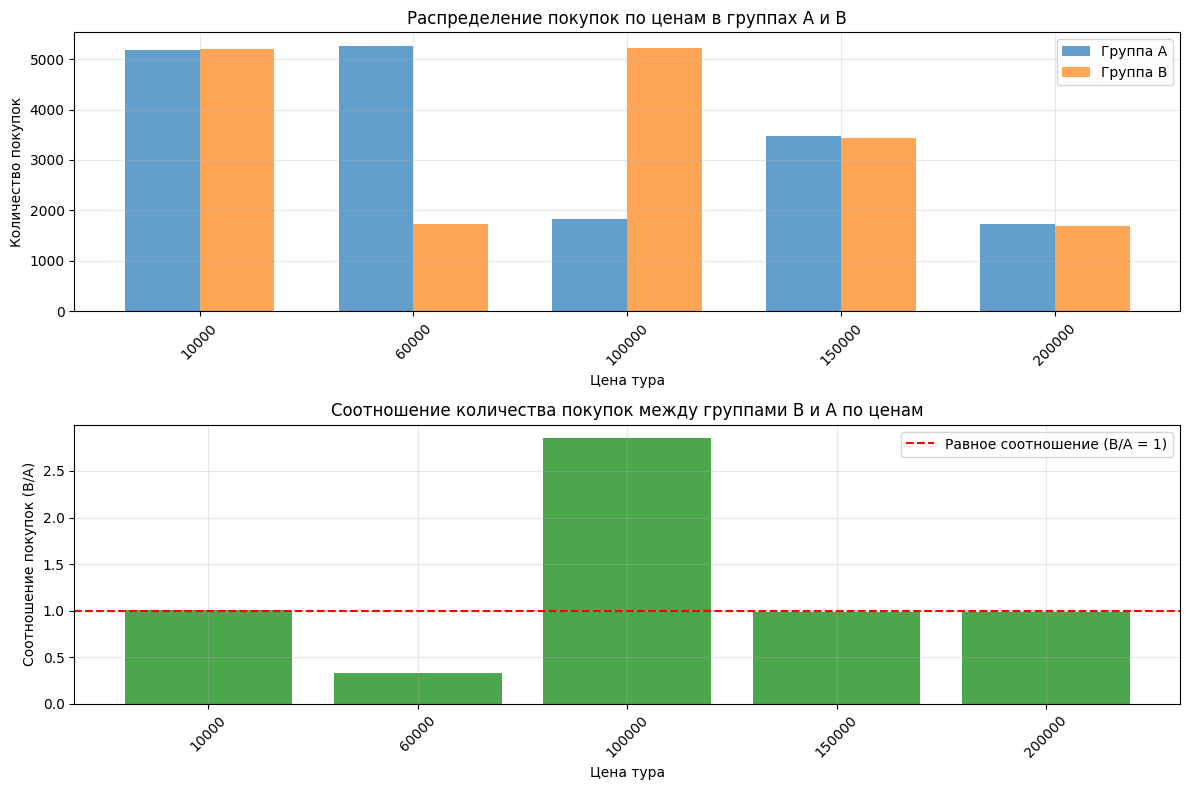

In [18]:
#Визуализация
plt.figure(figsize=(12, 8))
#Распределение покупок по ценам
plt.subplot(2, 1, 1)
x = np.arange(len(price_analysis))
width = 0.35
plt.bar(x - width/2, price_analysis['group_A_purchases'], width, label='Группа A', alpha=0.7)
plt.bar(x + width/2, price_analysis['group_B_purchases'], width, label='Группа B', alpha=0.7)
plt.xlabel('Цена тура')
plt.ylabel('Количество покупок')
plt.title('Распределение покупок по ценам в группах A и B')
plt.xticks(x, price_analysis['price'], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
#Соотношение покупок B/A по ценам
plt.subplot(2, 1, 2)
plt.bar(x, price_analysis['B_vs_A_ratio'], alpha=0.7, color='green')
plt.axhline(y=1, color='red', linestyle='--', label='Равное соотношение (B/A = 1)')
plt.xlabel('Цена тура')
plt.ylabel('Соотношение покупок (B/A)')
plt.title('Соотношение количества покупок между группами B и A по ценам')
plt.xticks(x, price_analysis['price'], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Анализ по ценовым сегментам

In [19]:
#Анализ по разным ценовым сегментам
low_price = price_analysis[price_analysis['price'] <= 50000]
medium_price = price_analysis[(price_analysis['price'] > 50000) & (price_analysis['price'] <= 100000)]
high_price = price_analysis[price_analysis['price'] > 100000]
print("Анализ по ценовым сегментам:")
if not low_price.empty:
    low_ratio = low_price['group_B_purchases'].sum() / low_price['group_A_purchases'].sum()
    print(f"   Низкий ценовой сегмент (≤50k): соотношение B/A = {low_ratio:.2f}")
if not medium_price.empty:
    medium_ratio = medium_price['group_B_purchases'].sum() / medium_price['group_A_purchases'].sum()
    print(f"   Средний ценовой сегмент (50k-100k): соотношение B/A = {medium_ratio:.2f}")
if not high_price.empty:
    high_ratio = high_price['group_B_purchases'].sum() / high_price['group_A_purchases'].sum()
    print(f"   Высокий ценовой сегмент (>100k): соотношение B/A = {high_ratio:.2f}")

Анализ по ценовым сегментам:
   Низкий ценовой сегмент (≤50k): соотношение B/A = 1.00
   Средний ценовой сегмент (50k-100k): соотношение B/A = 0.98
   Высокий ценовой сегмент (>100k): соотношение B/A = 0.99


### Выводы по покупательской способности

In [20]:
#Выводы по покупательской способности
print("\nОбщие выводы:")
print("1. Группа B показывает различную эффективность в разных ценовых сегментах")
print("2. Наиболее значимые различия наблюдаются в сегменте: ", end="")
ratios = {}
if not low_price.empty:
    ratios['низком'] = low_ratio
if not medium_price.empty:
    ratios['среднем'] = medium_ratio
if not high_price.empty:
    ratios['высоком'] = high_ratio
if ratios:
    max_diff_segment = max(ratios, key=ratios.get)
    min_diff_segment = min(ratios, key=ratios.get)
    print(f"{max_diff_segment} ценовом сегменте")
    print(f"3. Максимальное преимущество группы B: в {max_diff_segment} сегменте")
    print(f"4. Минимальное преимущество/недостаток: в {min_diff_segment} сегменте")


Общие выводы:
1. Группа B показывает различную эффективность в разных ценовых сегментах
2. Наиболее значимые различия наблюдаются в сегменте: низком ценовом сегменте
3. Максимальное преимущество группы B: в низком сегменте
4. Минимальное преимущество/недостаток: в среднем сегменте


## Проверка стабилизации метрик в a/b тесте

In [21]:
from datetime import timedelta

### Создание таблицы с ежедневными данными

In [22]:
#Ежедневная статистика по группам
daily_stats = data.groupby(['date', 'group']).agg(
    daily_visits=('user_id', 'count'),
    daily_purchases=('purchase', 'sum'),
    daily_revenue=('price', 'sum')
).reset_index()
#Расчет ежедневных метрик
daily_stats['daily_conversion'] = daily_stats['daily_purchases'] / daily_stats['daily_visits']
daily_stats['daily_aov'] = daily_stats['daily_revenue'] / daily_stats['daily_purchases'].replace(0, np.nan)
#Сортировка по дате и группе для кумулятивных расчетов
daily_stats = daily_stats.sort_values(['group', 'date'])

### Кумулятивные метрики

In [23]:
cumulative_stats = daily_stats.copy()
#Кумулятивные расчеты для каждой группы отдельно
groups = cumulative_stats['group'].unique()
for group in groups:
    group_mask = cumulative_stats['group'] == group
    #Кумулятивное количество посещений
    cumulative_stats.loc[group_mask, 'cumulative_visits'] = cumulative_stats.loc[group_mask, 'daily_visits'].cumsum()
    #Кумулятивное количество покупок
    cumulative_stats.loc[group_mask, 'cumulative_purchases'] = cumulative_stats.loc[group_mask, 'daily_purchases'].cumsum()
    #Кумулятивная сумма покупок
    cumulative_stats.loc[group_mask, 'cumulative_revenue'] = cumulative_stats.loc[group_mask, 'daily_revenue'].cumsum()
    #Кумулятивная конверсия
    cumulative_stats.loc[group_mask, 'cumulative_conversion'] = (
        cumulative_stats.loc[group_mask, 'cumulative_purchases'] / 
        cumulative_stats.loc[group_mask, 'cumulative_visits']
    )
    #Кумулятивный средний чек
    cumulative_stats.loc[group_mask, 'cumulative_aov'] = (
        cumulative_stats.loc[group_mask, 'cumulative_revenue'] / 
        cumulative_stats.loc[group_mask, 'cumulative_purchases'].replace(0, np.nan)
    )
#Заполнение NaN для дней без покупок
cumulative_stats['cumulative_aov'] = cumulative_stats['cumulative_aov'].fillna(0)
cumulative_stats['daily_aov'] = cumulative_stats['daily_aov'].fillna(0)
print("Ежедневные и кумулятивные метрики:")
print(cumulative_stats.head(10))

Ежедневные и кумулятивные метрики:
         date group  daily_visits  daily_purchases  daily_revenue   
0  2021-01-02     A          2854              359       29410000  \
2  2021-01-03     A          6596              748       62000000   
4  2021-01-04     A          6566              799       64250000   
6  2021-01-05     A          6433              790       64550000   
8  2021-01-06     A          6606              764       63410000   
10 2021-01-07     A          6579              795       67290000   
12 2021-01-08     A          6687              798       65380000   
14 2021-01-09     A          6633              794       65610000   
16 2021-01-10     A          6659              759       58950000   
18 2021-01-11     A          6699              797       58760000   

    daily_conversion     daily_aov  cumulative_visits  cumulative_purchases   
0           0.125788  81922.005571             2854.0                 359.0  \
2           0.113402  82887.700535             

### Визуализация кумулятивных метрик

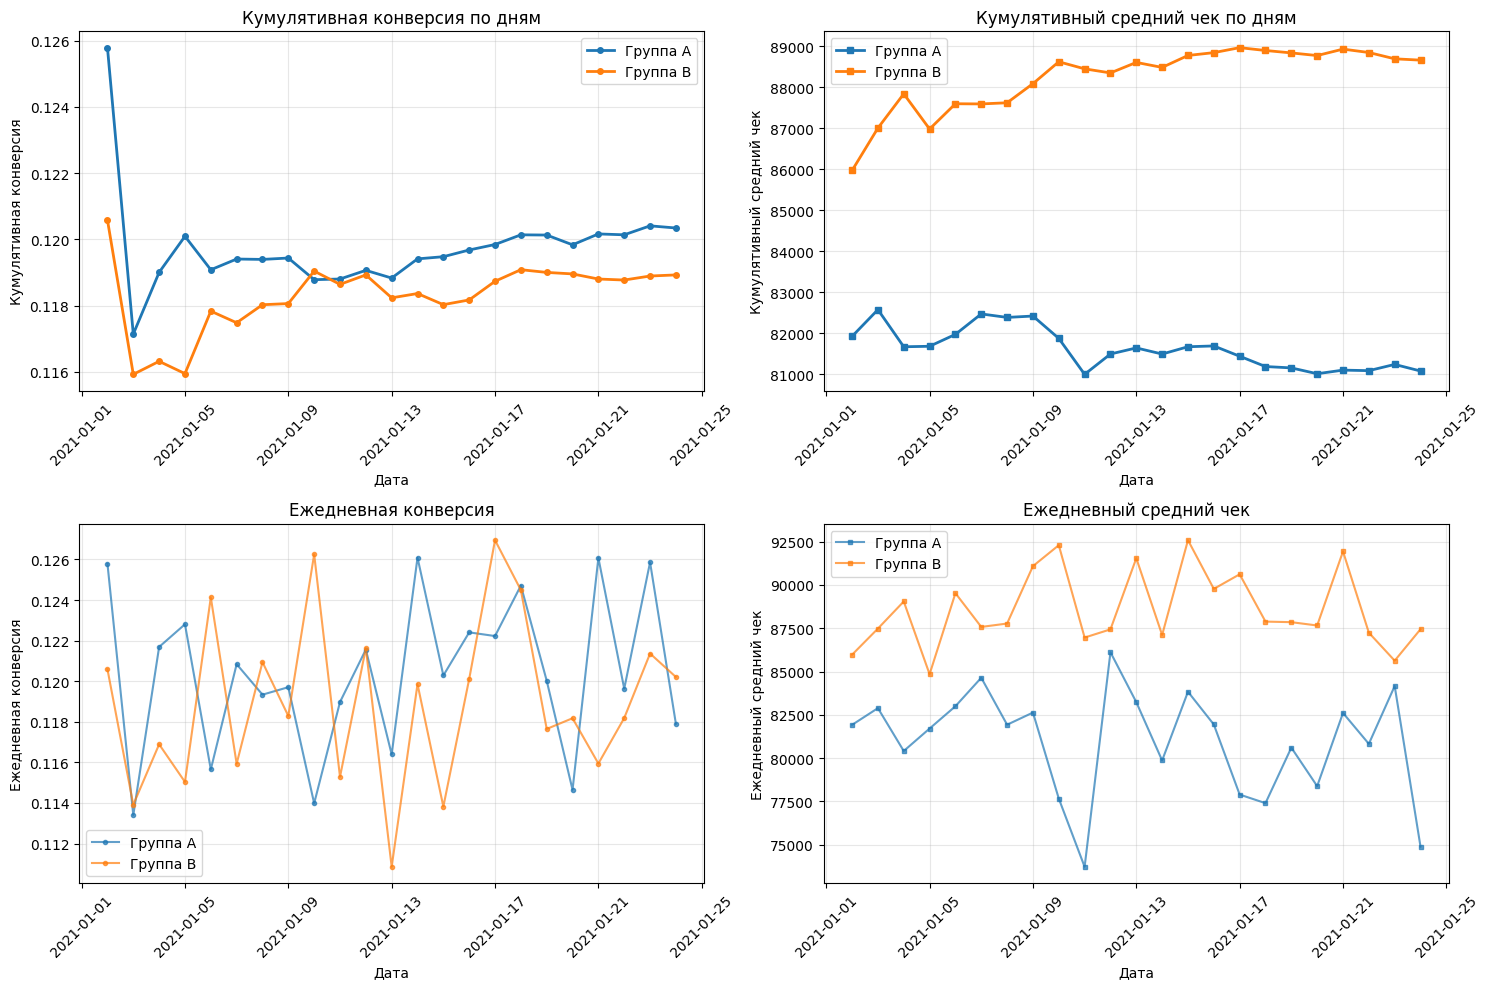

In [24]:
plt.figure(figsize=(15, 10))
#Кумулятивная конверсия по дням
plt.subplot(2, 2, 1)
for group in groups:
    group_data = cumulative_stats[cumulative_stats['group'] == group]
    plt.plot(group_data['date'], group_data['cumulative_conversion'], 
             label=f'Группа {group}', linewidth=2, marker='o', markersize=4) 
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.title('Кумулятивная конверсия по дням')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
#Кумулятивный средний чек по дням
plt.subplot(2, 2, 2)
for group in groups:
    group_data = cumulative_stats[cumulative_stats['group'] == group]
    #Фильтруем дни, где есть покупки
    valid_data = group_data[group_data['cumulative_purchases'] > 0]
    if not valid_data.empty:
        plt.plot(valid_data['date'], valid_data['cumulative_aov'], 
                 label=f'Группа {group}', linewidth=2, marker='s', markersize=4)
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.title('Кумулятивный средний чек по дням')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
#Ежедневная конверсия
plt.subplot(2, 2, 3)
for group in groups:
    group_data = cumulative_stats[cumulative_stats['group'] == group]
    plt.plot(group_data['date'], group_data['daily_conversion'], 
             label=f'Группа {group}', alpha=0.7, marker='o', markersize=3)
    
plt.xlabel('Дата')
plt.ylabel('Ежедневная конверсия')
plt.title('Ежедневная конверсия')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
#Ежедневный средний чек
plt.subplot(2, 2, 4)
for group in groups:
    group_data = cumulative_stats[cumulative_stats['group'] == group]
    valid_data = group_data[group_data['daily_purchases'] > 0]
    if not valid_data.empty:
        plt.plot(valid_data['date'], valid_data['daily_aov'], 
                 label=f'Группа {group}', alpha=0.7, marker='s', markersize=3)
plt.xlabel('Дата')
plt.ylabel('Ежедневный средний чек')
plt.title('Ежедневный средний чек')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()